In [1]:
import re
import numpy as np
import pandas as pd
import segyio
import tqdm
import matplotlib
import cv2
from joblib import Parallel, delayed
import math
import glob
import os
from PIL import Image
from matplotlib import cm
import itertools

%pylab inline 

filename_trn_full = 'data/cube/trainset.sgy'
filename_trn_layers = 'data/cube/trainset_mask.sgy'

Populating the interactive namespace from numpy and matplotlib


### <font color="green"> Read SEGY files</font>

In [2]:
def get_segy_info(filename):
    with segyio.open(filename, ignore_geometry=True) as f:
        # Get basic attributes
        n_traces = f.tracecount
        sample_rate = segyio.tools.dt(f) / 1000
        n_samples = f.samples.size
        twt = f.samples
    return n_traces, sample_rate, n_samples, twt

In [3]:
# Full cube
n_traces, sample_rate, n_samples, twt = get_segy_info(filename_trn_full)
print('Full_cube')
print('N Traces: {}, N Samples: {}, Sample rate: {}ms, Trace length: {}'.format(n_traces,
                                                                                n_samples,
                                                                                sample_rate,
                                                                                max(twt)))
# Layers mask
n_traces, sample_rate, n_samples, twt = get_segy_info(filename_trn_layers)
print('Layers_mask')
print('N Traces: {}, N Samples: {}, Sample rate: {}ms, Trace length: {}'.format(n_traces,
                                                                                n_samples,
                                                                                sample_rate,
                                                                                max(twt)))

Full_cube
N Traces: 196608, N Samples: 384, Sample rate: 2.0ms, Trace length: 2562.0
Layers_mask
N Traces: 196608, N Samples: 384, Sample rate: 2.0ms, Trace length: 2562.0


In [4]:
# Open files
segyfile_full_trn = segyio.open(filename_trn_full, 'r')
segyfile_layers_trn = segyio.open(filename_trn_layers, 'r')
segyfile_full_trn.mmap(), segyfile_layers_trn.mmap()

(True, True)

#### Read geometric info

In [5]:
print('Full cube')
print('  Crosslines: ', segyfile_full_trn.xlines[0], ':', segyfile_full_trn.xlines[-1], ' | lngth:',len(segyfile_full_trn.xlines))
print('  Inlines:    ', segyfile_full_trn.ilines[0], ':', segyfile_full_trn.ilines[-1], ' | lngth:',len(segyfile_full_trn.ilines))

Full cube
  Crosslines:  2017 : 2400  | lngth: 384
  Inlines:     3160 : 3671  | lngth: 512


In [6]:
384+512

896

### Load xline, iline, mask and crop

In [7]:
%%time
i=300
trn_inline = segyfile_full_trn.ilines[i]

iline_full_trn = segyfile_full_trn.iline[trn_inline]
iline_layers_trn = segyfile_layers_trn.iline[trn_inline]  
print(iline_layers_trn.sum().sum())
print(iline_full_trn.shape, iline_layers_trn.shape)

348253
(384, 384) (384, 384)
CPU times: user 5.71 ms, sys: 341 µs, total: 6.05 ms
Wall time: 5.36 ms


In [8]:
iline_full_trn_cut = iline_full_trn[~np.all(iline_full_trn == 0, axis=1)].T
iline_layers_trn_cut = iline_layers_trn[~np.all(iline_full_trn == 0, axis=1)].T

iline_full_trn_cut.shape, iline_layers_trn_cut.shape

((384, 384), (384, 384))

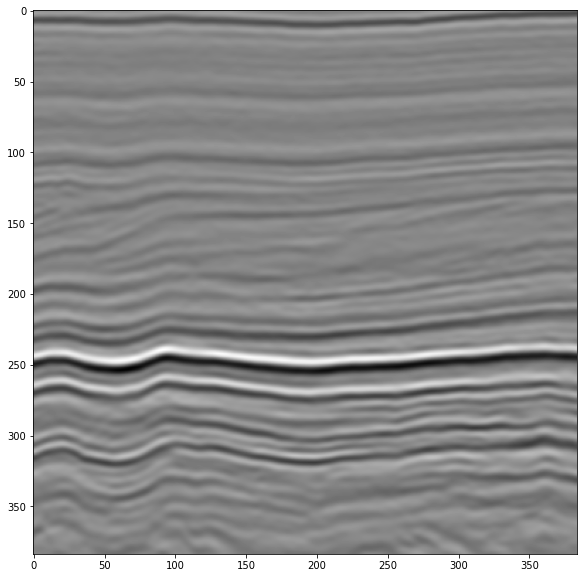

In [9]:
plt.figure(figsize=(20,10))
img = iline_full_trn_cut

plt.imshow(img, cmap='gray');

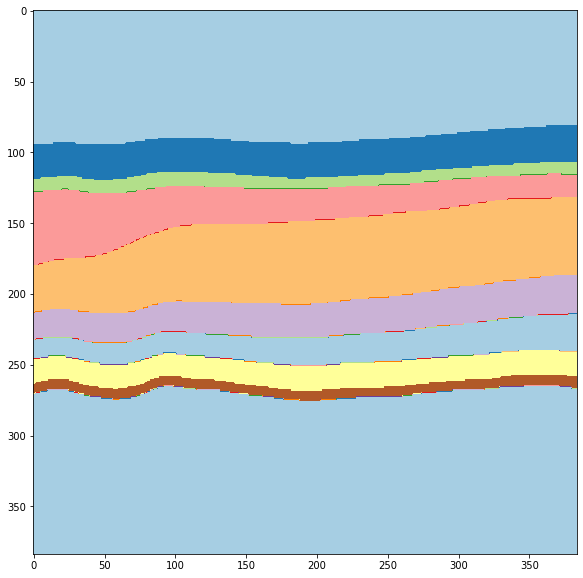

In [10]:
plt.figure(figsize=(20,10))
msk = iline_layers_trn_cut

plt.imshow(msk, cmap='Paired');

#### Load inline and mask

In [11]:
img_trn_path = 'data/train/images/'
msk_trn_path = 'data/train/masks/'

def crop_save(line_full, line_layers, img_path, msk_path, line, idx):
    # Crop
    line_full_cut = line_full[~np.all(line_full == 0, axis=1)].T
    line_layers_cut = line_layers[~np.all(line_full == 0, axis=1)].T
    line_layers_cut = 10*line_layers_cut + 127                 
    line_layers_cut = cv2.merge((line_layers_cut,line_layers_cut,line_layers_cut))                 
    # Save
    matplotlib.image.imsave(img_path+line+'_'+str(idx)+'.png', line_full_cut, cmap='gray')
    matplotlib.image.imsave(msk_path+line+'_'+str(idx)+'.png', line_layers_cut.astype(np.uint8))

def get_images(segyfile_full_trn, segyfile_layers_trn):   

    for line in ['inline', 'xline']:
        print(line+'...')
        
        if line == 'inline':
            line_cnt = range(len(segyfile_full_trn.ilines))
        else:
            line_cnt = range(len(segyfile_full_trn.xlines))

        for i in tqdm.tqdm_notebook(line_cnt):
            if line == 'inline':
                idx = segyfile_full_trn.ilines[i]
                if idx in segyfile_full_trn.ilines:
                    line_full_trn = segyfile_full_trn.iline[idx]
                    line_layers_trn = segyfile_layers_trn.iline[idx]
                    # Crop and save
                    crop_save(line_full_trn, line_layers_trn, img_trn_path, msk_trn_path, line, idx)         
            else:  
                if idx in segyfile_full_trn.xlines:
                    line_full_trn = segyfile_full_trn.xline[idx]
                    line_layers_trn = segyfile_layers_trn.xline[idx]
                    # Crop and save
                    crop_save(line_full_trn, line_layers_trn, img_trn_path, msk_trn_path, line, idx) 
                             

# Open files
segyfile_full_trn = segyio.open(filename_trn_full, 'r')
segyfile_layers_trn = segyio.open(filename_trn_layers, 'r')
# 
get_images(segyfile_full_trn, segyfile_layers_trn)

inline...


/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



xline...


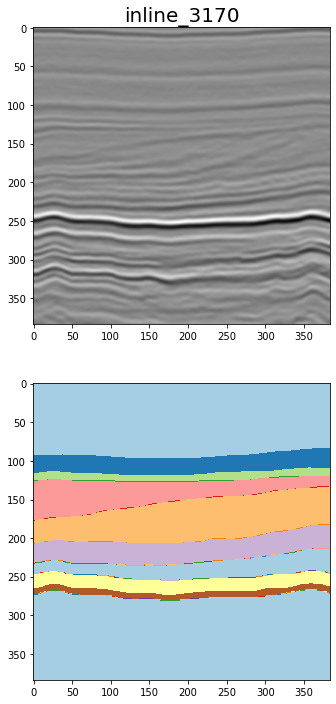

In [12]:
plt.figure(figsize=(12,12))
plt.subplot(2, 2, 1)
img = cv2.imread(img_trn_path+'inline'+'_'+str(3170)+'.png')
plt.imshow(img, cmap='gray')
plt.title('inline'+'_'+str(3170), fontsize=20)
plt.subplot(2, 2, 3)
msk = cv2.imread(msk_trn_path+'inline'+'_'+str(3170)+'.png')
plt.imshow(msk[:,:,0], cmap='Paired')